In [10]:
import os
import os.path
import json

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [11]:
gpus = pd.read_csv('./gpu.csv')
gpus

,name,short_name,bandwidth_GBs,Unnamed: 3
0,NVIDIA A100 80GB PCIe,GA100,1996,NaN
1,Tesla T4,TU104,320,NaN
2,Tesla V100-PCIE-16GB,GV100,897,NaN
3,Tesla M60,GM204,160,NaN


In [12]:
results = {}
for root, dirs, files in os.walk("../output"):
    for file in files:
        if file.endswith('.json'):
            path = os.path.join(root, file)
            #if "phi" in file: 
            #    print(file)
            #    continue
            with open(path, "r") as f:
                results[path] = json.load(f)

In [13]:
flat = [ {
    "file": key,
    "model": value["model"],
    "nb_params": value["model_info"]["model_info"]["general.parameter_count"],
    "quantization": value["model_info"]["details"]["quantization_level"],
    "gpu_used_warmup": value["gpu_info_warmup"]["used_memory"],
    "gpu_used_done": value["gpu_info_done"]["used_memory"],
    "gpu_name": value["gpu_info_done"]["name"],
    "per_sec": value["results"]["summary"]["per_sec"]
} for key, value in results.items() ]

NVIDIA A100 80GB PCIe
Tesla M60
Tesla T4
Tesla V100-PCIE-16GB


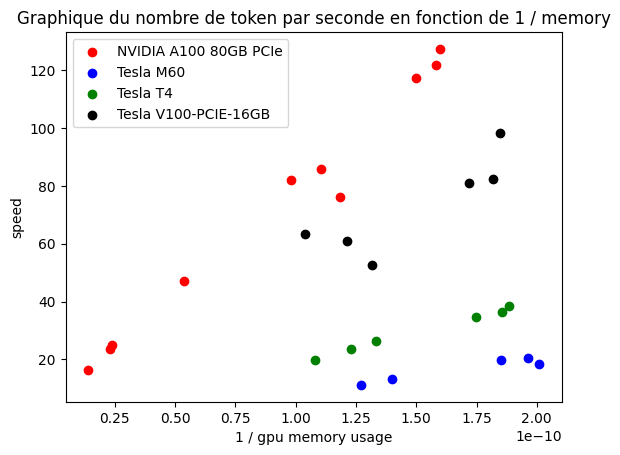

In [14]:
df = pd.json_normalize(flat)
df = pd.merge(df, gpus, left_on="gpu_name", right_on="name")
df = df[df["nb_params"] > 4000000000]


# Créer le scatter plot
fig, ax = plt.subplots()

colors = ["red", "blue", "green", "black"]
i = 0
for gpu, group in df.groupby("gpu_name"):
    print(gpu)
    ax.scatter(1 / group['gpu_used_done'], group['per_sec'], label=gpu, color=colors[i])
    
    i+=1

ax.legend()
plt.xlabel('1 / gpu memory usage')
plt.ylabel('speed')
plt.title('Graphique du nombre de token par seconde en fonction de 1 / memory')
plt.show()

In [15]:
df.columns

Index(['file', 'model', 'nb_params', 'quantization', 'gpu_used_warmup',
       'gpu_used_done', 'gpu_name', 'per_sec', 'name', ' short_name',
       'bandwidth_GBs', 'Unnamed: 3'],
      dtype='object')

NVIDIA A100 80GB PCIe
Tesla M60
Tesla T4
Tesla V100-PCIE-16GB


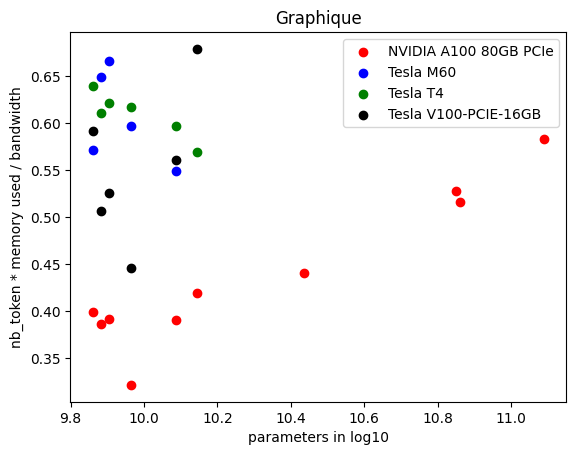

In [16]:
# Créer le scatter plot
fig, ax = plt.subplots()

colors = ["red", "blue", "green", "black"]
i = 0
for gpu, group in df.groupby("gpu_name"):
    print(gpu)
    ax.scatter(np.log10(group['nb_params']), (group['gpu_used_done'] * group['per_sec']) / (group["bandwidth_GBs"] * 1000000000), label=gpu, color=colors[i])
    
    i+=1

ax.legend()
plt.xlabel('parameters in log10')
plt.ylabel('nb_token * memory used / bandwidth')
plt.title('Graphique')
plt.show()

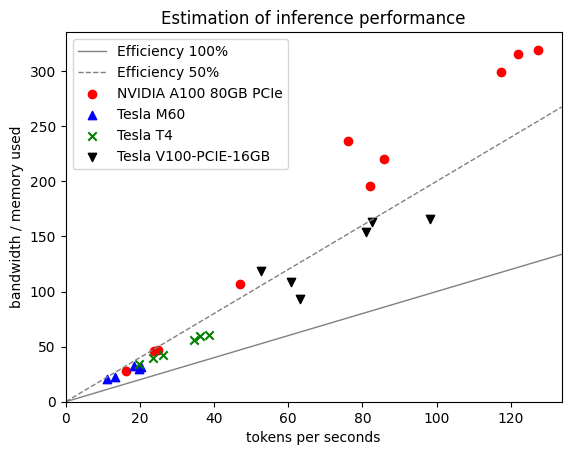

In [18]:

# Créer le scatter plot
fig, ax = plt.subplots()

colors = ["red", "blue", "green", "black"]
markers = ["o", "^", "x", "v"]
i = 0
ax.axline((0, 0), slope=1., color='grey', ls="-", lw=1, label='Efficiency 100%')
ax.axline((0, 0), slope=2., color='grey', ls="--", lw=1, label='Efficiency 50%')
for gpu, group in df.groupby("gpu_name"):
    ax.scatter(group['per_sec'], (group['bandwidth_GBs'] * 1000000000) / group['gpu_used_done'],  label=gpu, marker=markers[i], color=colors[i])
    
    i+=1

ax.legend()
ax.set_xlim(0)
ax.set_ylim(0)
plt.xlabel('tokens per seconds')
plt.ylabel('bandwidth / memory used')
plt.title('Estimation of inference performance')
plt.savefig('estimation.png')
plt.show()
